# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from shapely import geometry, ops
import fiona
import geopandas as gpd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

# Instatiate a grid

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')
grid.read_raster('../data/n30w100_dir', data_name='dir')

# Specify flow direction values

In [3]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Clip to a smaller area

In [4]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Clip to catchment
grid.clip_to('catch')

# Create vector representation of catchment mask

In [5]:
# Calling grid.polygonize without arguments will default to the catchment mask
shapes = grid.polygonize()

# Is equivalent to...
shapes = grid.polygonize(grid.mask.astype(np.uint8))

# Write to shapefile

In [6]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('catchment.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

# Read created shapefile

In [7]:
shp = gpd.read_file('catchment.shp')

# Inspect created shapefile

In [8]:
shp

,LABEL,geometry
0,1,POLYGON ((-97.29166666666677 32.73916666666656...


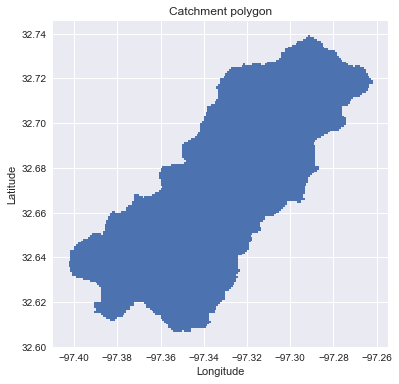

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

# Write river network to shapefile

In [10]:
# grid.extract_river_network outputs geojson, which is a little different
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')
branches = grid.extract_river_network('catch', 'acc', threshold=50, dirmap=dirmap)

In [11]:
schema = {
    'geometry': 'LineString',
    'properties': {}
}

with fiona.open('rivers.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for branch in branches['features']:
        rec = {}
        rec['geometry'] = branch['geometry']
        rec['properties'] = {}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

# Read created shapefile

In [12]:
shp = gpd.read_file('rivers.shp')

# Inspect created shapefile

In [13]:
shp.head()

,FID,geometry
0,0,LINESTRING (-97.2950000000001 32.7383333333332...
1,1,LINESTRING (-97.29416666666677 32.737499999999...
2,2,LINESTRING (-97.29416666666677 32.737499999999...
3,3,LINESTRING (-97.29750000000011 32.731666666666...
4,4,LINESTRING (-97.29750000000011 32.731666666666...


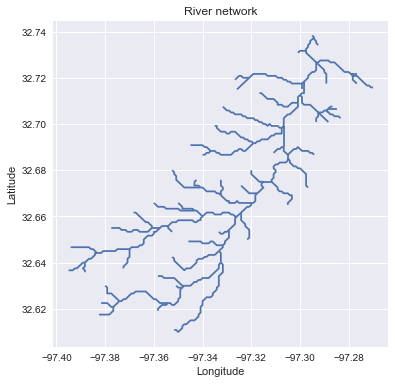

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network')